In [1]:
%cd ../

/home/eugenrudic/PycharmProjects/mt-tabnet-xgboost-model-comparison


In [2]:
import argparse
from genericpath import exists
import json
import pickle
import os
from fastai.tabular.all import EarlyStoppingCallback, SaveModelCallback, GradientClip, CSVLogger
from model_trainer.tabnet.utils import get_optimizer_from_params
from model_trainer.tabnet.tabnet_trainer import TabNetTrainer
from model_trainer.data import data_loader
from model_trainer.data.process_only_data_box import ProccessOnlyDataBox
from tuning_config import spaces, base_class_weights_large
import data_config
from hyperopt import space_eval
import numpy as np
from torch import tensor
# TODO: import this
from fast_tabnet.core import tabnet_explain, tabnet_feature_importances
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, matthews_corrcoef

def process_params(params):
    cw_modifier = params.pop('cw_modifier')
    class_weights = base_class_weights_large.copy()
    class_weights[1]=class_weights[1]*cw_modifier
    class_weights = tensor(np.array(class_weights,dtype='f'))
    batch_size = int(np.power(2, params.pop('batch_size')))
    params['virtual_batch_size'] = int(
        np.power(2, params['virtual_batch_size']))

    opt_params = params.pop('optimizer')
    opttype = opt_params.pop('opttype')
    lookahead = opt_params.pop('lookahead')
    lr = opt_params.pop('lr')
    optimizer = get_optimizer_from_params(opttype, opt_params, lookahead)

    n = params.pop('n')
    params['n_d'] = n
    params['n_a'] = n
    return params, optimizer, batch_size, class_weights, lr

In [12]:
data_size="small"
evals=10
base_data_path="data"
epochs=1
patience=1
info_output_path="info-test"

print("Loading data")
X_train, Y_train = data_loader.load(
    data_size, base_data_path, 'train_val')
X_test, Y_test = data_loader.load(
    data_size,base_data_path,'test' 
)
print("Processing data")
po_db = ProccessOnlyDataBox(X_train, Y_train, X_test, Y_test, data_config.categorical_variables)
X_train, Y_train, X_test, Y_test = next(po_db.get_processed_data())

os.makedirs(info_output_path,exist_ok=True) # creating info output dir
callbacks = [
    CSVLogger(fname=f'{info_output_path}/train_history.csv', append=False),
    GradientClip(),
    EarlyStoppingCallback(
        monitor='valid_loss',
        patience=patience,
        reset_on_fit=True
    ),
    SaveModelCallback(
        monitor='matthews_corrcoef',
        fname=f'tabnet-{data_size}-model',
        at_end=False,
        with_opt=True,
        reset_on_fit=True
    )
]

trials_in_path = f"trials/tabnet-{data_size}.p"
print(f"Loading trial from path: {trials_in_path}")
with open(trials_in_path, 'rb') as in_file:
    trials = pickle.load(in_file)

space = spaces['tabnet'][data_size]
best_hyperparams = space_eval(space, trials.argmin)
print(f"Starting training with best params:\n{json.dumps(best_hyperparams,indent=4)}")
model_params, optimizer, batch_size, class_weights,lr = process_params(best_hyperparams)
# TODO: F1, accuracy, confusion metrics
tt = TabNetTrainer(lr,model_params, optimizer,
            batch_size, callbacks, class_weights)
model = tt.train(X_train, Y_train, X_test, Y_test, data_config.continous_variables,epochs)
preds = np.array(tt.get_preds(model)).flatten()
f1 = f1_score(Y_test,preds)


Loading data
Processing data
Loading trial from path: trials/tabnet-small.p
Starting training with best params:
{
    "batch_size": 8.0,
    "cw_modifier": 1.5,
    "gamma": 1.6764244526616359,
    "momentum": 0.6341653649702229,
    "n": 32,
    "n_steps": 4,
    "optimizer": {
        "lookahead": true,
        "lr": 0.008776074534175875,
        "opttype": "Adam",
        "wd": 0.0015690117123744126
    },
    "virtual_batch_size": 5.0
}
[0, 1.2998634576797485, 1.309848666191101, 0.12853446310469255, '01:25']
Better model found at epoch 0 with matthews_corrcoef value: 0.12853446310469255.


/tmp/ipykernel_105581/2261912221.py:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds = np.array(tt.get_preds(model)).flatten()
/tmp/ipykernel_105581/2261912221.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(tt.get_preds(model)).flatten()


ValueError: Found input variables with inconsistent numbers of samples: [56907, 2]

In [63]:
preds_0=np.argmax(np.array(preds[0]),axis=1)
mcc = matthews_corrcoef(Y_test,preds_0)
print(f"mcc: {mcc}")
f1_weighted = f1_score(Y_test,preds_0,average='weighted')
print(f"f1 weighted: {f1_weighted}")
accuracy = accuracy_score(Y_test,preds_0)
print(f"accuracy: {accuracy}%")
confusion_mat = confusion_matrix(Y_test,preds_0)
print(f"confusion mat:\n{confusion_mat}")

metrics = {
    "mcc": mcc,
    "f1": f1_weighted,
    "confusion_m":confusion_mat,
    "acc": accuracy
}



mcc: 0.12721114133965727
f1 weighted: 0.7724315605251912
accuracy: 0.7279420809390761%
confusion mat:
[[  194   298    19    10]
 [ 4096 40114  4771  1679]
 [  237  1766   865   234]
 [  218  1526   628   252]]


In [38]:
Y_test

0        2
1        1
2        2
3        1
4        0
        ..
56902    3
56903    1
56904    1
56905    1
56906    1
Name: Severity, Length: 56907, dtype: int64

In [69]:
model.dls.valid

In [74]:
feature_importances = tabnet_feature_importances(model.model, model.dls.valid)
res_explain, res_masks = tabnet_explain(model.model, model.dls.valid)
feature_importances

array([1.56288895e-02, 1.25226194e-02, 1.74126431e-01, 1.59807221e-02,
       1.20521301e-02, 3.01515389e-02, 1.61758538e-02, 1.05908551e-02,
       8.89569303e-03, 2.06691747e-02, 1.02287423e-02, 7.60866235e-03,
       4.21855456e-03, 1.29581150e-02, 1.96339245e-02, 4.27339994e-02,
       5.36039260e-04, 8.14122236e-03, 5.61088411e-03, 9.56969026e-03,
       2.25572817e-03, 7.05388808e-03, 1.27144514e-02, 2.75276995e-02,
       5.44186545e-02, 3.02090502e-02, 8.76048625e-03, 1.90960296e-02,
       1.41408485e-02, 4.82778045e-03, 3.20087348e-03, 2.50785308e-02,
       4.82084305e-03, 7.98021361e-03, 7.32489069e-03, 7.06507517e-03,
       4.77374664e-03, 9.93959729e-03, 8.44549853e-03, 1.22633247e-01,
       3.37705042e-03, 2.46052299e-03, 6.02004391e-03, 1.30675401e-02,
       4.10480855e-03, 5.72278754e-03, 1.64016120e-03, 1.37252806e-03,
       9.49715036e-04, 1.42170576e-03, 7.90921625e-02, 9.92033497e-03,
       3.91662790e-03, 1.93142733e-03, 6.66911225e-03, 2.04891804e-02,
      

In [3]:
from model_trainer.tabnet import utils
import pickle

In [4]:
with open('info-test/feature_and_res.p','rb') as f:
    feature_and_res = pickle.load(f)

In [5]:
feature_and_res.keys()

dict_keys(['x_names', 'feature_importances', 'res_explain', 'res_masks'])

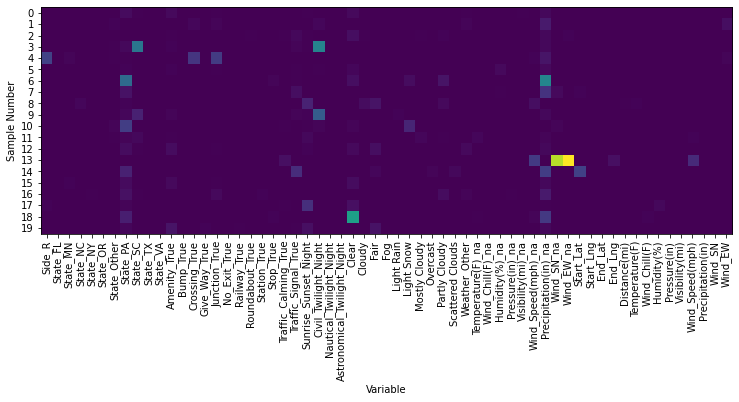

In [6]:
masks = feature_and_res['res_explain']
x_names = feature_and_res['x_names']
feature_importances = feature_and_res['feature_importances']
utils.plot_explain(masks[20:40],x_names)

In [7]:
masks.shape

(56907, 61)

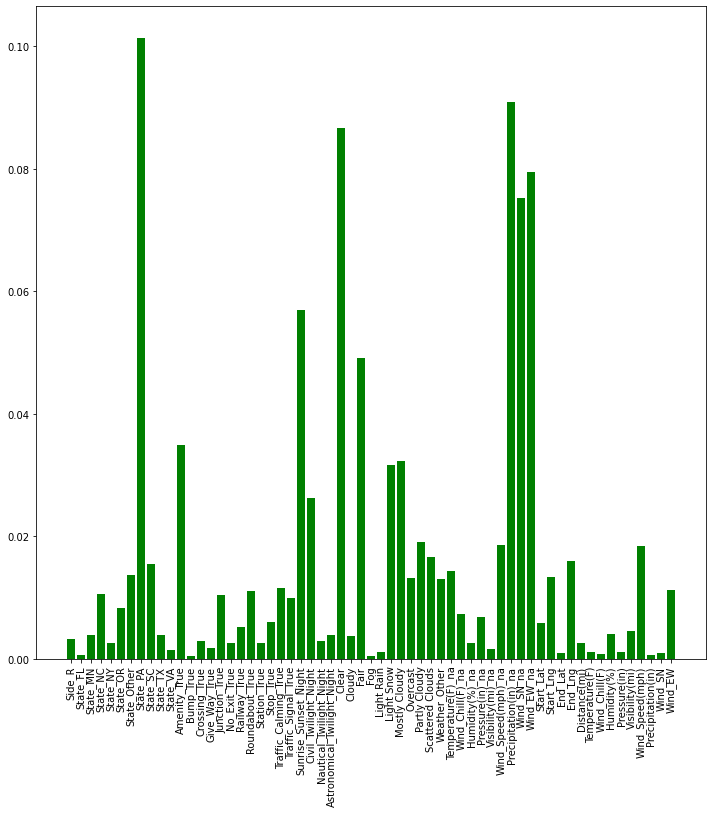

In [8]:
utils.plot_feature_importances(feature_importances,x_names)

In [10]:
with open('info-test/metrics.p','rb') as f:
    metrics = pickle.load(f)
print(metrics)

{'mcc': 0.14719131973162636, 'f1': 0.7848992329419465, 'confusion_m': array([[  107,   378,    33,     3],
       [ 1395, 41047,  5858,  2360],
       [   58,  1723,   941,   380],
       [   63,  1435,   685,   441]]), 'acc': 0.7474651624580456}


In [27]:
model.dls.valid.to('cuda').device

'cuda'

In [26]:
tabnet_explain(model.model, model.dls.valid.

AttributeError: cpu

In [22]:
model.dls.valid

In [24]:
model.dls.valid.to('cuda')